In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

#spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder.master("local[10]").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

df = spark.read.parquet("run1011_mwdc.parquet")
df.show(5)

+---------+------------------+-----------+---------------+---------------+-------------------+-----------+---------------+---------------+-------------------+-----------+---------------+---------------+-------------------+-----------+---------------+---------------+-------------------+-----------+---------------+---------------+-------------------+-----------+---------------+---------------+------------------+-----------+---------------+---------------+-------------------+-----------+---------------+---------------+-------------------+-----------+---------------+---------------+------------------+-----------+---------------+---------------+-------------------+-----------+---------------+---------------+-------------------+-----------+---------------+---------------+-------+
|hbfNumber|        dc31_x1_dl|dc31_x1_id0|dc31_x1_charge0|dc31_x1_timing0|         dc31_x2_dl|dc31_x2_id0|dc31_x2_charge0|dc31_x2_timing0|         dc31_y1_dl|dc31_y1_id0|dc31_y1_charge0|dc31_y1_timing0|         dc31

Statistics:
[[    0.     0.     0.]
 [    0. 43354.     0.]
 [    0.     0.     0.]]
Statistics:
[[    0.     0.     0.]
 [    0. 40444.     0.]
 [    0.     0.     0.]]
Statistics:
[[    0.     0.     0.]
 [    0. 43483.     0.]
 [    0.     0.     0.]]
Statistics:
[[    0.     0.     0.]
 [    0. 40307.     0.]
 [    0.     0.     0.]]
Statistics:
[[    0.  1751.     0.]
 [    0. 42039.     0.]
 [    0.   633.     0.]]
Statistics:
[[    0.     0.     0.]
 [    0. 38311.     0.]
 [    0.   920.     0.]]
Statistics:
[[    0.  6024.     0.]
 [    0. 39269.     0.]
 [    0.  1961.     0.]]
Statistics:
[[    0.     0.     0.]
 [    0. 34861.     0.]
 [    0.  1588.     0.]]
Statistics:
[[    0.     0.     0.]
 [    0. 38223.     0.]
 [    0.  1196.     0.]]
Statistics:
[[    0.  2277.     0.]
 [    0. 41132.     0.]
 [    0.   469.     0.]]
Statistics:
[[    0.     0.     0.]
 [    0. 42825.     0.]
 [    0.     0.     0.]]
Statistics:
[[    0.     0.     0.]
 [    0. 39169.     0.]
 [   

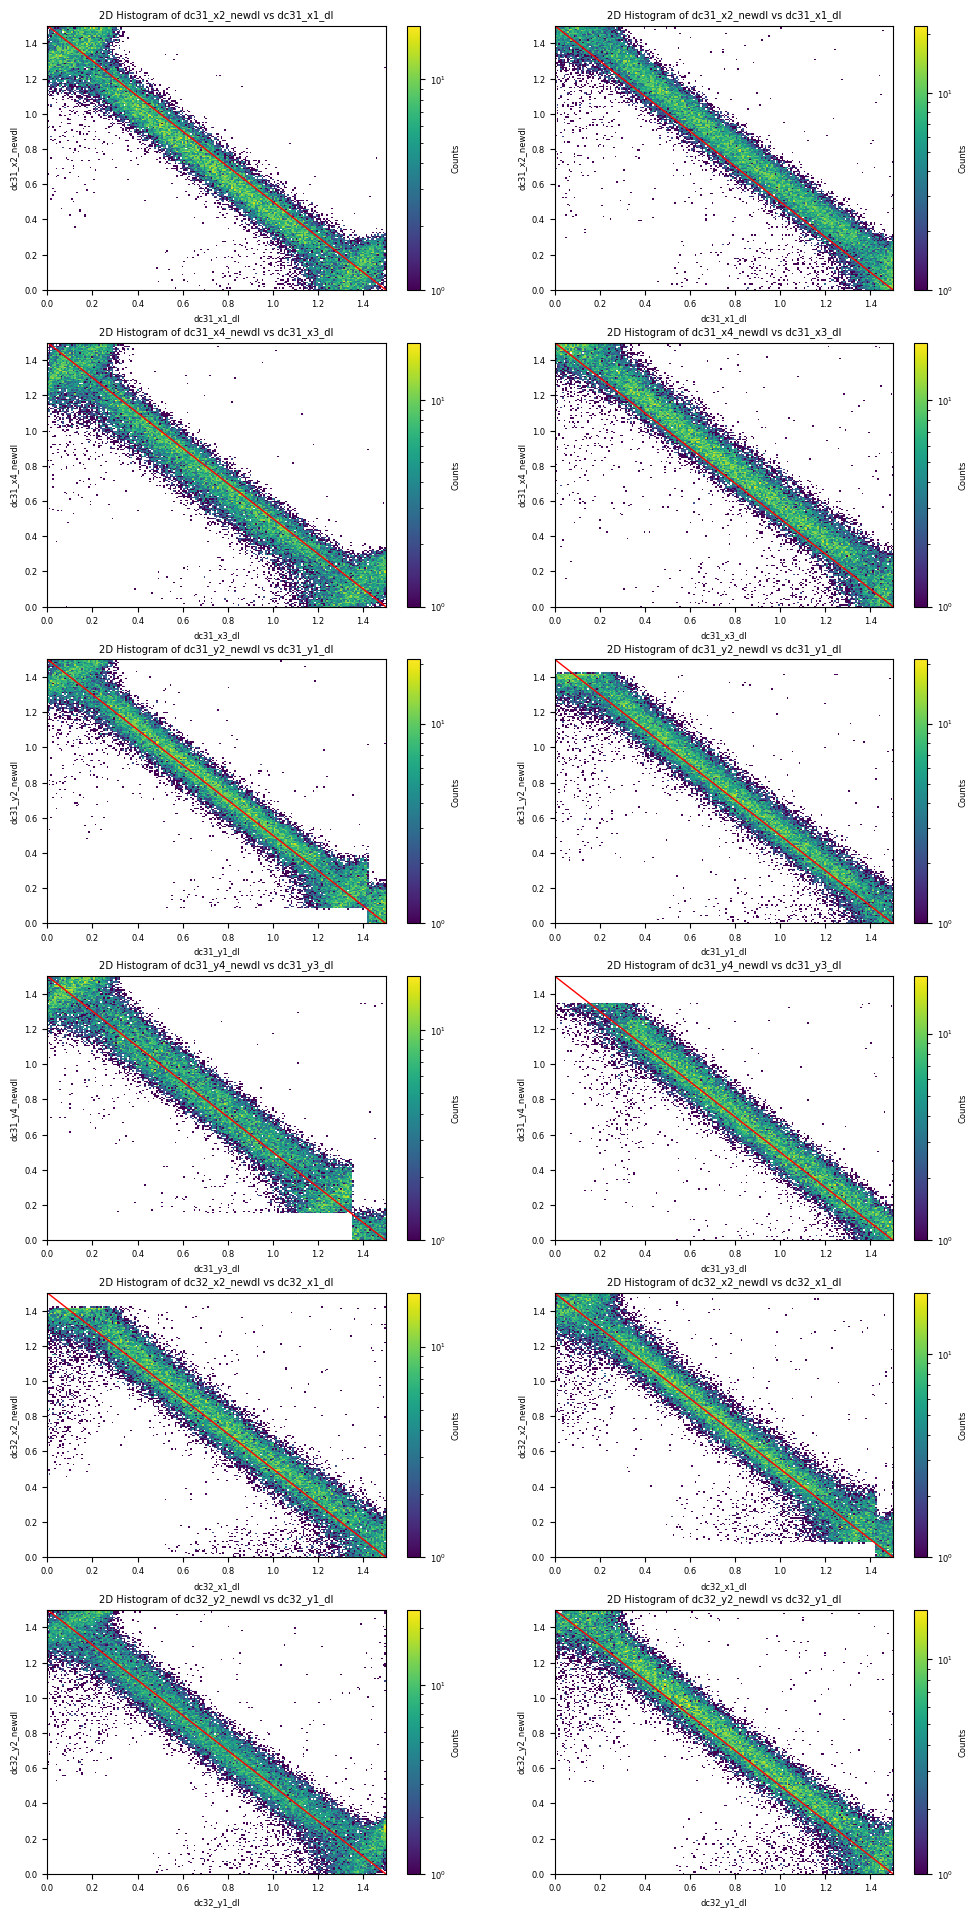

In [29]:
planes = [('dc31_x1', 'dc31_x2'), ('dc31_x3', 'dc31_x4'), ('dc31_y1', 'dc31_y2'), ('dc31_y3', 'dc31_y4'), ('dc32_x1', 'dc32_x2'), ('dc32_y1', 'dc32_y2')]
shifts = [0.0, 0.0, 0.08, 0.15, -0.08, 0.0]
cellsize = 3.0

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from hist.sparkHist2d import Hist2D

plt.figure(0, figsize=(12,24))
plt.rcParams["font.size"] = 6
for i, plane_pair in enumerate(planes):
    shift2 = shifts[i]
    plane1, plane2 = plane_pair
    if shift2 > 0:
        outdataframe = df.withColumn(
            plane2 + "_newdl",
            F.when(F.col(plane1 + "_id0") != F.col(plane2 + "_id0"),
                   F.col(plane2 + "_dl") - shift2)
            .when((F.col(plane1 + "_id0") == F.col(plane2 + "_id0")) & 
                  (F.col(plane1 + "_dl") > cellsize / 2 - shift2),
                   F.col(plane2 + "_dl") - shift2)
            .otherwise(F.col(plane2 + "_dl") + shift2)
        )
    else:
        outdataframe = df.withColumn(
            plane2 + "_newdl",
            F.when(F.col(plane1 + "_id0") == F.col(plane2 + "_id0"),
                   F.col(plane2 + "_dl")+ shift2 )
            .when((F.col(plane1 + "_id0") != F.col(plane2 + "_id0")) & 
                  (F.col(plane1 + "_dl") > cellsize / 2 - abs(shift2)),
                   F.col(plane2 + "_dl")+shift2)
            .otherwise( F.col(plane2 + "_dl")-shift2)
        )
    
    plt.subplot2grid((6,2),(i,0))
    d = Hist2D(outdataframe.filter(f"{plane1}_id0 == {plane2}_id0"), [f"{plane1}_dl",f"{plane2}_newdl"],[200,200],[[0,1.5],[0,1.5]],  interpolation='none', norm=LogNorm())
    plt.plot([0, 1.5], [1.5, 0], 'r-', linewidth=1)
    plt.subplot2grid((6,2),(i,1))
    d = Hist2D(outdataframe.filter(f"{plane1}_id0 != {plane2}_id0"), [f"{plane1}_dl",f"{plane2}_newdl"],[200,200],[[0,1.5],[0,1.5]],  interpolation='none', norm=LogNorm())
    plt.plot([0, 1.5], [1.5, 0], 'r-', linewidth=1)

plt.show()